# Instructions

As in the previous assignment, youl'll be using PyTorch instead of EDF. This assignment will focus on generative modelling, and you'll implement and train a VAE and a GAN.

It is highly suggested to use google colab and run the notebook on a GPU node.
Check https://colab.research.google.com/ and look for tutorials online on how to use it. To use a GPU go to Runtime -> Change runtime type and select GPU.

In [1]:
%matplotlib inline
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(0)
#torch.set_deterministic(True)
np.random.seed(0)

In this second part of the assignment you'll train a VAE and a GAN on a more interesting dataset. The cell below will try to download and load CelebA, and will just load MNIST in case there is an error.

It is likely that you'll get an error when trying to download CelebA since the its google drive is always out of quota. If you'd like to use CelebA anyway, you can try to download it from here http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or some other source. If you're not running this notebook on a GPU then use MNIST instead.

## VAE and GANs on CelebA/MNIST

In [4]:
transform = transforms.Compose([
    transforms.Resize(64), 
    transforms.CenterCrop(64),
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))])

In [5]:
dataset = datasets.CelebA("data", split='all', download=True, transform=transform)
N_IN_CHANNELS = 3 # RGB image

Files already downloaded and verified


In [6]:
BATCH_SIZE = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
# from google.colab.patches import cv2_imshow
import cv2

def show(x):
    img = x.data.cpu().permute(1, 2, 0).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # cv2_imshow(img)
    plt.figure()
    plt.imshow(img)
    plt.show()

We'll use a a CNN for the VAE instead of the simple model we defined previously.
Implement a network following these specifications:

- Encoder. Should have 4 conv layers, each with kernel size 4, stride 2 and padding 1, which decrease the spatial resolution by half. The output of the 4th conv (a spatial res. 4x4) should be flattened and then fully connected layers should be used to compute mu and logvar. Add whichever activation function you prefer between the conv layers (ReLU, LeakyReLU, ELU, etc), and feel free to add batch norm as well. Let the first conv layer have, say, 8 or 16 channels and then double the number of channels at each following conv layer.

- Decoder. Try to have an architecture that is roughly symmetric to the encoder. For example, start with a fully connected layer to project the latent_dim dimensional input such that you end up with a (128x4x4)-dimensional vector that you can reshape into a 4x4 image. Then you can apply 4 transposed conv layers, e.g. with kernel size 4, stride 2 and padding 1, to double the spatial resolution with each layer, having a final output of size 64x64. Start with around 64 or 128 channels for the first transposed conv and then halve the number of channels at each following conv layer. As before, add your preferred activation function between layers, with or without batch norm.

The encode, sample, and decode methods have the same specification as before.

In [11]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim, n_in_channels):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        n_channels = 16
        self.n_channels = n_channels
        
        self.encoder = nn.Sequential(
            nn.Conv2d(n_in_channels, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 2, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 4, n_channels * 8, 4, 2, 1),
            nn.Flatten()
        )
        
        self.flat_dim = n_channels * 8 * 4 * 4
        self.mu = nn.Linear(self.flat_dim, latent_dim)
        self.logvar = nn.Linear(self.flat_dim, latent_dim)
        
        self.decoder_fc = nn.Linear(latent_dim, self.flat_dim)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n_channels * 8, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 4, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 2, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels, n_in_channels, 4, 2, 1),
        )
        
    def encode(self, input):
        # implementation goes here
        x = self.encoder(input)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar
    
    def sample(self, mu, logvar):
        # implementation goes here
        epsilon = torch.normal(0., 1., size=mu.size()).cuda()
        std = torch.exp(logvar * 0.5) 
        z = epsilon * std + mu
        return z
    
    def decode(self, input):
        # implementation goes here
        out = self.decoder_fc(input)
        out = out.reshape(-1, self.n_channels * 8, 4, 4)
        out = self.decoder(out)
        return out
        
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.sample(mu, logvar)
        out = self.decode(z)
        return mu, logvar, out
    
    def generate(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [12]:
def loss(x, out, mu, logvar, beta, sigma=1):
    # implementation goes here
    recons_loss = ((out - x) * (out - x)).sum()
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    loss = recons_loss + beta * kld_loss
    return recons_loss, kld_loss, loss

In [13]:
vae = ConvVAE(100, N_IN_CHANNELS).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

The cell below applies a 'patch' in case you're using google colab (cv2_imshow doesn't work properly on google colab without it). Feel free to comment out the first import if you're not using google colab (you might have to add from cv2 import cv2_imshow, though).

Again, try to find a value for beta that yields reasonable results.

recons_loss 137017.546875, kld_loss 1.0185489654541016


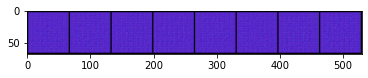

recons_loss 10884.796875, kld_loss 4530.89208984375


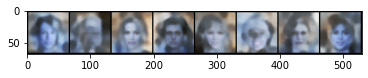

recons_loss 11346.865234375, kld_loss 4519.8125


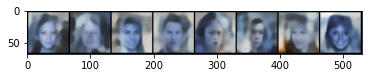

recons_loss 10383.6787109375, kld_loss 4427.927734375


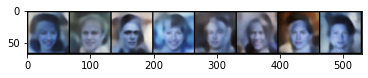

recons_loss 10037.88671875, kld_loss 4488.3935546875


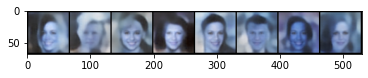

recons_loss 9604.56640625, kld_loss 4402.05029296875


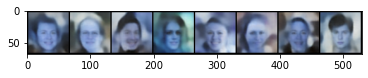

recons_loss 9512.6923828125, kld_loss 4308.7998046875


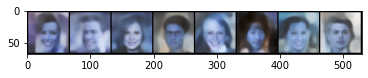

recons_loss 9817.173828125, kld_loss 4638.9716796875


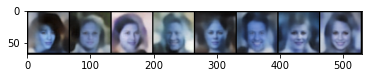

recons_loss 10396.107421875, kld_loss 4278.0556640625


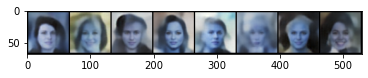

recons_loss 10391.7119140625, kld_loss 4326.998046875


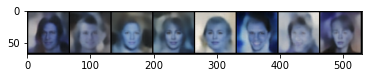

recons_loss 8348.841796875, kld_loss 4157.1044921875


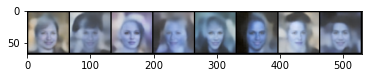

recons_loss 10516.681640625, kld_loss 4528.9873046875


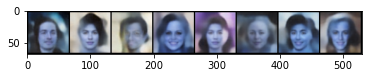

recons_loss 10032.486328125, kld_loss 4430.46484375


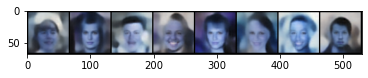

recons_loss 10940.953125, kld_loss 4462.8681640625


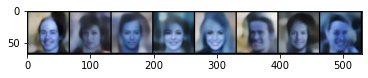

recons_loss 10369.53125, kld_loss 4558.779296875


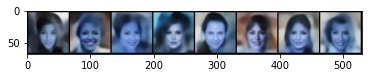

recons_loss 9688.275390625, kld_loss 4438.41845703125


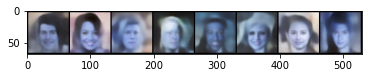

recons_loss 10512.5380859375, kld_loss 4418.93359375


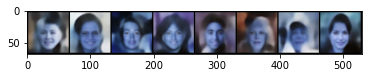

recons_loss 10347.4365234375, kld_loss 4754.044921875


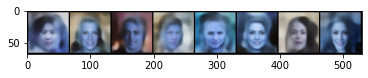

recons_loss 10352.744140625, kld_loss 4504.8427734375


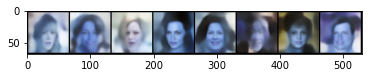

recons_loss 10919.13671875, kld_loss 4553.48193359375


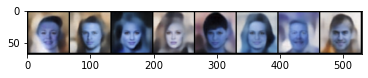

recons_loss 10574.462890625, kld_loss 4428.18017578125


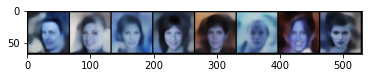

recons_loss 8704.01171875, kld_loss 4422.46826171875


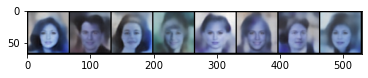

recons_loss 9268.779296875, kld_loss 4211.2255859375


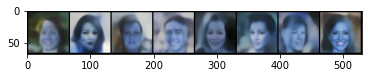

recons_loss 10085.115234375, kld_loss 4404.580078125


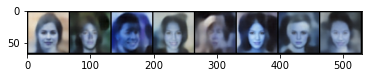

recons_loss 8385.71875, kld_loss 4256.31103515625


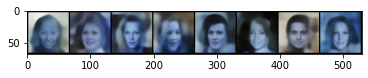

recons_loss 9662.6298828125, kld_loss 4292.00048828125


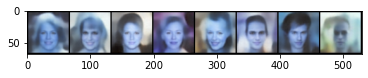

recons_loss 10570.830078125, kld_loss 4533.83935546875


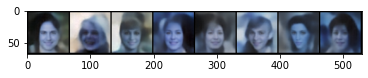

recons_loss 8883.544921875, kld_loss 4498.5439453125


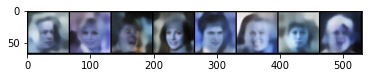

recons_loss 8670.625, kld_loss 4295.25927734375


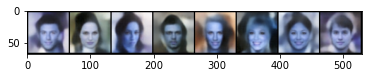

recons_loss 8761.935546875, kld_loss 4124.0771484375


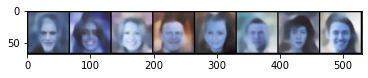

In [15]:
beta = 0.9
for epoch in range(30):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda()
        
        mu, logvar, out = vae(x)
        rl, kl, l = loss(x, out, mu, logvar, beta)

        opt.zero_grad()
        l.backward()
        opt.step()
        if i == 0:
            print('recons_loss {}, kld_loss {}'.format(rl.item(), kl.item()))
            vae.eval()
            data = vae.generate(8)
            grid_img = torchvision.utils.make_grid(data, nrow=8, normalize=True)
            show(grid_img)
            vae.train()

You'll also re-implement the Generator and Discriminator modules for the GAN, adopting a CNN-like architecture.

For the generator, implement a network similar to the one you used for the VAE decoder (fully connected for projection followed by 4 transposed convolutions), while for the discriminator you should use a network similar to the VAE encoder (4 conv layers with stride 2, but note that the output should be a scalar per image, not a latent vector).

In [7]:
class ConvGenerator(nn.Module):
    def __init__(self, latent_dim, n_in_channels):
        super(ConvGenerator, self).__init__()
        self.latent_dim = latent_dim

        n_channels = 16
        self.n_channels = n_channels
        self.flat_dim = n_channels * 8 * 4 * 4
        
        self.decoder_fc = nn.Linear(latent_dim, self.flat_dim)
        self.network = nn.Sequential(
            nn.ConvTranspose2d(n_channels * 8, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 4, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 2, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels, n_in_channels, 4, 2, 1)
        )
    
    def decode(self, input):
        # implementation goes here
        out = self.decoder_fc(input) 
        out = out.reshape(-1, self.n_channels * 8, 4, 4)
        out = self.network(out)
        return out

    def forward(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [8]:
class ConvDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_in_channels):
        super(ConvDiscriminator, self).__init__()
        self.latent_dim = latent_dim

        n_channels = 16
        self.n_channels = n_channels
        self.flat_dim = n_channels * 8 * 4 * 4
        self.n_in_channels = n_in_channels
        
        self.network = nn.Sequential(
            nn.Conv2d(n_in_channels, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 2, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 4, n_channels * 8, 4, 2, 1),
            nn.Flatten(),
            nn.Linear(self.flat_dim, 1) # scalar output
            # no need for sigmoid as we are using BCEWithLogitsLoss
        )
    
    def forward(self, input):
        # implementation goes here 
        out = self.network(input)
        return out

In [9]:
generator = ConvGenerator(100, N_IN_CHANNELS).cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = ConvDiscriminator(100, N_IN_CHANNELS).cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

generator loss 1.0555546283721924, discriminator loss 0.9992287158966064


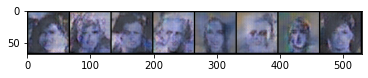

generator loss 3.4305670261383057, discriminator loss 0.5419454574584961


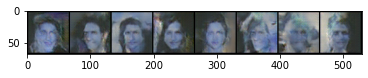

generator loss 2.477961301803589, discriminator loss 0.412841260433197


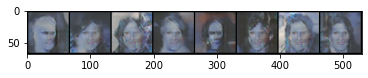

generator loss 1.7581851482391357, discriminator loss 0.4578106701374054


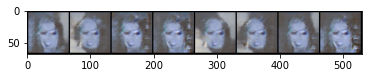

generator loss 3.7268893718719482, discriminator loss 0.6099696159362793


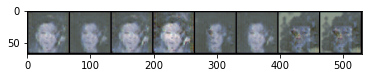

generator loss 3.3079543113708496, discriminator loss 0.21701601147651672


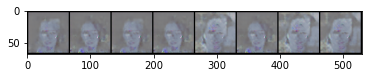

generator loss 1.9340195655822754, discriminator loss 0.8083239793777466


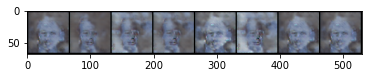

In [ ]:
for epoch in range(30):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda()

        real = x
        batch_size = x.shape[0]
        fake = generator(n=batch_size).cuda()
        labels_real = torch.ones((batch_size,), dtype=torch.float).cuda()
        labels_fake = torch.zeros((batch_size,), dtype=torch.float).cuda()

        # Train G
        # tell discriminator these are real data
        preds_fake = discriminator(fake).squeeze().cuda()
        gloss = criterion(preds_fake, labels_real)
        gopt.zero_grad()
        gloss.backward()
        gopt.step()

        # Train D
        # real
        preds_real = discriminator(real).squeeze().cuda()
        dloss = criterion(preds_real, labels_real)    
        # fake, detach so grad doesn't go into generator
        preds_fake = discriminator(fake.detach()).squeeze().cuda()
        dloss += criterion(preds_fake, labels_fake)
        dopt.zero_grad()
        dloss.backward()
        dopt.step()
        
        if i == 0:
            print('generator loss {}, discriminator loss {}'.format(gloss.item(), dloss.item()))
            grid_img = torchvision.utils.make_grid(fake[:8], nrow=8, normalize=True)
            show(grid_img)